In [1]:
import scanpy as sc

In [68]:
ad = sc.read_h5ad("/Volumes/processing2/RRmap/data/EAE_MANA_annotated_gmm_clust_with_scores_anno_comp.h5ad")

In [69]:
# Marker inspection + scoring for proliferation and apoptosis
import scanpy as sc

# Mouse gene symbols (adjust case if your panel uses uppercase)
prolif = [
    'Mki67','Top2a','Mcm2','Mcm3','Mcm4','Mcm5','Mcm6','Mcm7','Pcna','Tyms',
    'Cdk1','Ccna2','Ccnb1','Ccnb2','Cenpf','Aurka','Aurkb','Birc5','Ube2c'
]
apopt = [
    'Casp3','Casp7','Casp8','Casp9','Bax','Bak1','Bcl2l11','Bbc3','Pmaip1',
    'Fas','Fasl','Tnfrsf10b','Tnfsf10','Apaf1','Bid'
]

present_prolif = [g for g in prolif if g in ad.var_names]
present_apopt = [g for g in apopt if g in ad.var_names]

print('Proliferation in panel:', present_prolif)
print('Apoptosis in panel:', present_apopt)

# Score genes (safe to run even if list is short)
if len(present_prolif) > 0:
    sc.tl.score_genes(ad, present_prolif, score_name='prolif_score')
else:
    print('No proliferation markers found in var_names')

if len(present_apopt) > 0:
    sc.tl.score_genes(ad, present_apopt, score_name='apopt_score')
else:
    print('No apoptosis markers found in var_names')

# Basic summaries
cols = [c for c in ['prolif_score','apopt_score'] if c in ad.obs.columns]
ad.obs[cols].describe()


Proliferation in panel: ['Mki67', 'Top2a', 'Mcm2', 'Pcna', 'Cdk1', 'Ccna2', 'Ccnb1', 'Cenpf', 'Aurka', 'Aurkb', 'Birc5']
Apoptosis in panel: ['Casp3', 'Casp7', 'Casp8', 'Casp9', 'Bax', 'Bak1', 'Bcl2l11', 'Bbc3', 'Pmaip1', 'Fas', 'Fasl', 'Tnfsf10', 'Apaf1', 'Bid']


,prolif_score,apopt_score
count,877141.000000,877141.000000
mean,-0.015543,-0.026044
std,0.204601,0.193286
min,-0.366046,-0.510483
25%,-0.118719,-0.161601
50%,-0.068629,-0.062094
75%,0.000248,0.075712
max,3.094772,1.324996


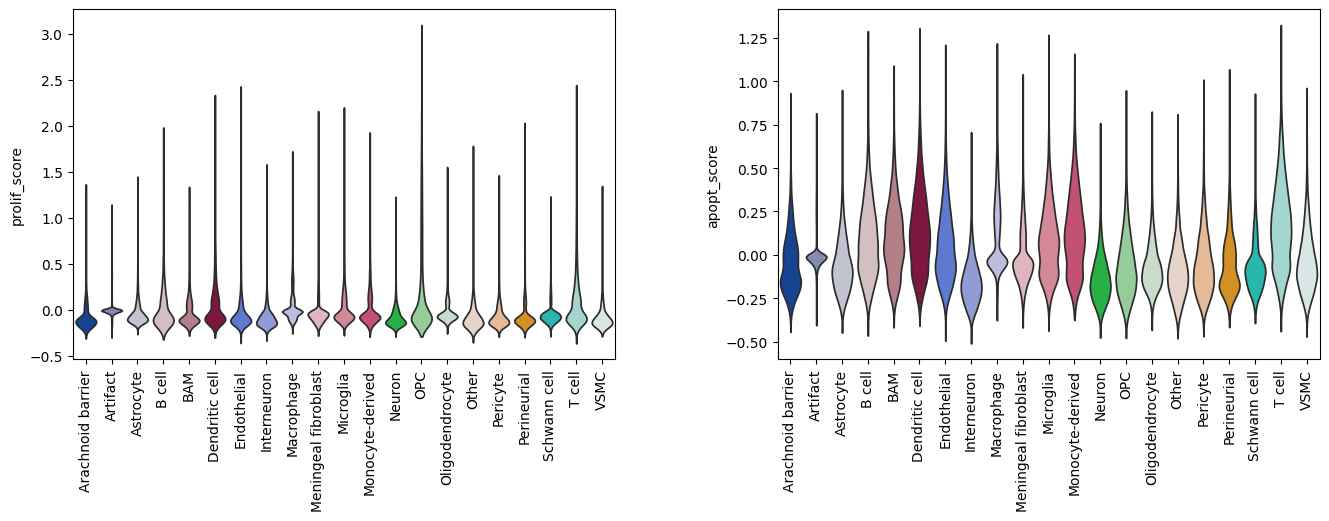

In [70]:
# Quick plots by annotated cell type (edit the column name if needed)
cell_type_col = 'anno_L2'
if cell_type_col in ad.obs.columns:
    sc.pl.violin(ad, keys=[c for c in ['prolif_score','apopt_score'] if c in ad.obs.columns],
                 groupby=cell_type_col, rotation=90, stripplot=False, jitter=False)
else:
    print(f'Missing cell type column: {cell_type_col}')


In [71]:
# Inspect obs columns to locate spatial coords and IDs
list(ad.obs.columns)[:50]


['cell',
 'centroid_x',
 'centroid_y',
 'centroid_z',
 'component',
 'volume',
 'surface_area',
 'scale',
 'region',
 'sample_id',
 'proseg_cluster',
 'output_folder',
 'Num',
 'n_genes',
 'n_counts',
 'louvain_0.5',
 'louvain_1',
 'louvain_1.5',
 'louvain_2',
 'louvain_2.5',
 'louvain_3',
 'louvain_3.5',
 'Cluster',
 'Level1',
 'Level2',
 'Level3',
 'Level3.1',
 'grid_label',
 'rbd_domain',
 'rbd_domain_0.1',
 'rbd_domain_0.2',
 'rbd_domain_0.3',
 'rbd_domain_0.5',
 'rbd_domain_0.6',
 'rbd_domain_0.7',
 'rbd_domain_0.8',
 'rbd_domain_0.9',
 'rbd_domain_1.1',
 'rbd_domain_1',
 'rbd_domain_1.25',
 'rbd_domain_1.4',
 'rbd_domain_1.5',
 'leiden_0.5',
 'leiden_1',
 'leiden_1.5',
 'leiden_2',
 'leiden_2.5',
 'leiden_3',
 'leiden_3.5',
 'sample_name']

In [72]:
# Build single_cell_df for OSDR
import numpy as np
import pandas as pd
from tdm.preprocess.single_cell_df import check_single_cell_df
from tdm.utils import microns

cell_type_col = 'anno_L2'

# Find x/y columns (edit if needed)
candidates = [
    ('x','y'),
    ('X','Y'),
    ('x_centroid','y_centroid'),
    ('X_centroid','Y_centroid'),
    ('centroid_x','centroid_y'),
]
x_col = y_col = None
for cx, cy in candidates:
    if cx in ad.obs.columns and cy in ad.obs.columns:
        x_col, y_col = cx, cy
        break
if x_col is None:
    raise ValueError('Could not find spatial columns. Set x_col/y_col manually.')

# Optional IDs (set to constants if missing)
img_id_col = 'fov_id' if 'fov_id' in ad.obs.columns else ('sample_id' if 'sample_id' in ad.obs.columns else None)
subject_id_col = 'subject_id' if 'subject_id' in ad.obs.columns else ('sample_id' if 'sample_id' in ad.obs.columns else None)

# Define dividing cells from prolif_score (adjust percentile as needed)
prolif_q = ad.obs['prolif_score'].quantile(0.98)
division = ad.obs['prolif_score'] >= prolif_q

# Assume coordinates are in microns; set to False if already in meters
coords_in_microns = True
x_vals = ad.obs[x_col].astype(float)
y_vals = ad.obs[y_col].astype(float)
if coords_in_microns:
    x_vals = microns(x_vals)
    y_vals = microns(y_vals)

single_cell_df = pd.DataFrame({
    'x': x_vals,
    'y': y_vals,
    'cell_type': ad.obs[cell_type_col].astype(str),
    'division': division.astype(bool),
    'img_id': ad.obs[img_id_col].astype(str) if img_id_col else '1',
    'subject_id': ad.obs[subject_id_col].astype(str) if subject_id_col else '1',
})

# Validate
check_single_cell_df(single_cell_df)


Validating single cell dataframe...

[SUCCESS] Found x column


                The spatial positions within the tissue should range from (0,0) to (x max, y max)
                
[SUCCESS] Found y column
[SUCCESS] Found cell_type column. Number of cell types: 21
	Cell types: ['Schwann cell', 'Artifact', 'Interneuron', 'Macrophage', 'Oligodendrocyte', 'Meningeal fibroblast', 'Microglia', 'Endothelial', 'Perineurial', 'T cell', 'Astrocyte', 'Monocyte-derived', 'Dendritic cell', 'OPC', 'Neuron', 'Pericyte', 'BAM', 'VSMC', 'B cell', 'Arachnoid barrier', 'Other']
[SUCCESS] Found division column. Fraction of dividing cells: 0.020
[SUCCESS] Found img_id column. Number of images found: 107
[SUCCESS] Found subject_id column. Number of subjects found: 107

[SUCCESS] Validation complete!


True

In [73]:
# Pick cell types to model (start with 2 for phase-portrait plots)
type_counts = single_cell_df['cell_type'].value_counts()
type_counts.head(20)


cell_type
Oligodendrocyte         174835
Interneuron             130506
Microglia               103816
Astrocyte               102125
Endothelial              60810
Meningeal fibroblast     42899
Macrophage               42745
Neuron                   39572
T cell                   31211
Schwann cell             24869
OPC                      21822
Arachnoid barrier        15851
BAM                      14443
Dendritic cell           14415
Artifact                  9699
B cell                    9680
Pericyte                  9643
VSMC                      8440
Perineurial               7482
Monocyte-derived          6380
Name: count, dtype: int64

In [75]:
cell_types_to_model

['Oligodendrocyte',
 'Interneuron',
 'Microglia',
 'Astrocyte',
 'Endothelial',
 'Meningeal fibroblast',
 'Macrophage',
 'Neuron',
 'T cell',
 'Schwann cell',
 'OPC',
 'Arachnoid barrier',
 'BAM',
 'Dendritic cell',
 'Artifact',
 'B cell',
 'Pericyte',
 'VSMC',
 'Perineurial',
 'Monocyte-derived']

In [108]:
# Select cell types to model
# Option A: manually set two types for a single phase portrait
cell_types_to_model = [
    'T cell','Meningeal fibroblast'#'OPC','T cell'# e.g. 'Microglia', 'T cell'
]

# Option B: auto-select top N types by abundance
auto_pick = False
top_n = 5
if auto_pick:
    cell_types_to_model = type_counts.head(top_n).index.tolist()

# Allowed neighbor types: start with the same set or extend
allowed_neighbor_types = cell_types_to_model


In [109]:
allowed_neighbor_types

['T cell', 'Meningeal fibroblast']

In [ ]:
# Run OSDR analysis for the selected cell types
from tdm.analysis import Analysis

ana = Analysis(
    single_cell_df=single_cell_df,
    cell_types_to_model=cell_types_to_model,
    allowed_neighbor_types=allowed_neighbor_types,
    polynomial_dataset_kwargs={'degree': 1},
    neighborhood_mode='extrapolate',
    enforce_max_density=False,
    model_kwargs={'regularization_alpha': 1e-3},
)


1/5 Constructing tissues [V]
2/5 Counting cell-neighbors 

/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/chrislangseth/miniforge3/envs/osd

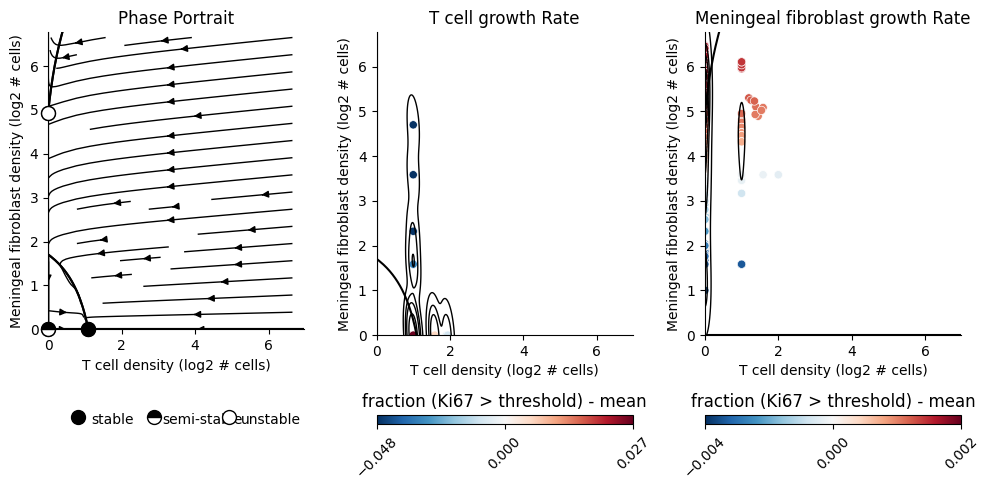

In [118]:
# Growth-rate plots (requires exactly 2 cell types)
from tdm.plot.two_cells import plot_growth_rate
import matplotlib.pyplot as plt

if len(cell_types_to_model) == 2:
    plot_growth_rate(ana)
    plt.show()
else:
    print('plot_growth_rate requires exactly 2 cell types')


In [119]:
cell_df = tissue.cell_df() # the rows of single_cell_df corresponding with this tissue
cell_df.head(50)

,x,y,division,cell_type,img_id,subject_id
cell_id,,,,,,
coocojim-1,0.006058,0.000688,False,T cell,S1_B3_2,S1_B3_2
cookmkjg-1,0.006066,0.000681,False,Arachnoid barrier,S1_B3_2,S1_B3_2
cooidbdd-1,0.006072,0.000685,False,Meningeal fibroblast,S1_B3_2,S1_B3_2
copcpgno-1,0.006069,0.000693,False,T cell,S1_B3_2,S1_B3_2
cdlboejc-1,0.006189,0.000631,False,Arachnoid barrier,S1_B3_2,S1_B3_2
cdnmkbbd-1,0.006197,0.000613,False,Arachnoid barrier,S1_B3_2,S1_B3_2
cdlamdph-1,0.006199,0.000621,False,Arachnoid barrier,S1_B3_2,S1_B3_2
cdlnkhbe-1,0.006203,0.000628,False,Arachnoid barrier,S1_B3_2,S1_B3_2
cechlami-1,0.006295,0.000492,False,Meningeal fibroblast,S1_B3_2,S1_B3_2


In [122]:
from tdm.cell_types import CELL_FULL_NAME_TO_COLOR, CELL_TYPE_TO_FULL_NAME

# Ensure labels exist in full-name map
for ct in cell_types_to_model:
    CELL_TYPE_TO_FULL_NAME.setdefault(ct, ct)

# Ensure colors exist (fallback colors if missing)
default_colors = ["#4C78A8", "#F58518", "#54A24B", "#E45756", "#72B7B2", "#B279A2"]
for i, ct in enumerate(cell_types_to_model):
    if ct not in CELL_FULL_NAME_TO_COLOR:
        CELL_FULL_NAME_TO_COLOR[ct] = default_colors[i % len(default_colors)]


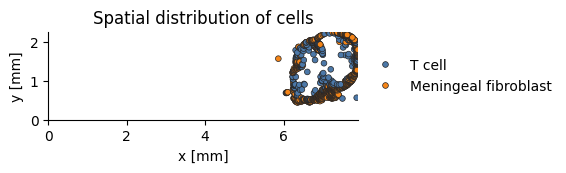

In [123]:
from tdm.plot.tissue import plot_tissue

tissue = ana.tissues[50]
plot_tissue(tissue)


/Users/chrislangseth/miniforge3/envs/osdr-py311/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


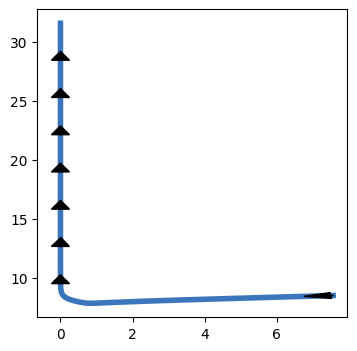

In [124]:
# Trajectory plot (requires exactly 2 cell types)
from tdm.plot.two_cells import plot_trajectory
from tdm.utils import log2_1p
import numpy as np
import matplotlib.pyplot as plt

if len(cell_types_to_model) == 2:
    # Use median per-tissue counts as a reasonable starting state
    counts = (
        single_cell_df.groupby(['img_id', 'cell_type'])
        .size()
        .unstack(fill_value=0)
    )
    init = counts[cell_types_to_model].median().values.tolist()
    state0 = log2_1p(np.array(init))
    ts = np.linspace(0, 2000, 2000)
    arrow_idxs = list(range(0, len(ts) - 2, 250))
    plot_trajectory(ana, state0=state0, odeint_timepoints=ts, arrow_timepoint_idxs=arrow_idxs)
    plt.show()
else:
    print('plot_trajectory requires exactly 2 cell types')


In [128]:
# Cross-validation (can be slow). Toggle run_cv to True if you want to run.
from tdm.model.selection import cross_validation2, plot_cross_validation_result

run_cv = False
if run_cv:
    model_dicts = {
        'deg1_l1e-3': {
            'polynomial_dataset_kwargs': {'degree': 1},
            'model_kwargs': {'regularization_alpha': 1e-3},
        },
        'deg1_l1e-2': {
            'polynomial_dataset_kwargs': {'degree': 1},
            'model_kwargs': {'regularization_alpha': 1e-2},
        },
    }
    res = cross_validation2(
        single_cell_df=single_cell_df,
        model_dicts=model_dicts,
        cell_types_to_model=cell_types_to_model,
        allowed_neighbor_types=allowed_neighbor_types,
        neighborhood_mode='extrapolate',
        n_splits=5,
    )
    plot_cross_validation_result(res)
else:
    print('Set run_cv=True to run cross-validation')


Set run_cv=True to run cross-validation


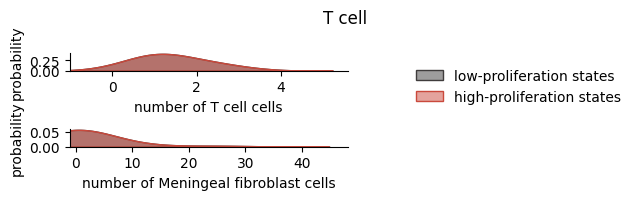

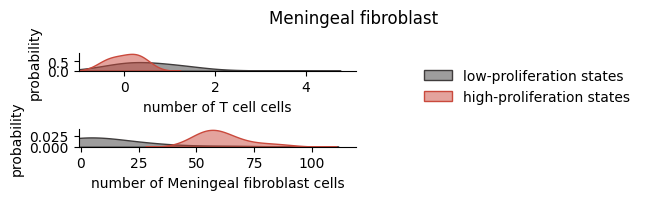

In [129]:
# Model-fit diagnostics (distributions driving high/low proliferation)
from tdm.plot.model.interpret import plot_high_and_low_proliferation_states

plot_high_and_low_proliferation_states(ana, plot_background_distribution=False)


In [90]:
single_cell_df[single_cell_df.division].cell_type.value_counts()

cell_type
Microglia               6224
OPC                     3954
T cell                  2133
Endothelial              969
Dendritic cell           812
Macrophage               647
Meningeal fibroblast     630
Oligodendrocyte          599
Astrocyte                480
B cell                   248
Interneuron              182
Monocyte-derived         106
Perineurial              105
Neuron                    96
BAM                       87
Arachnoid barrier         71
Pericyte                  66
Schwann cell              57
Artifact                  28
VSMC                      26
Other                     23
Name: count, dtype: int64

In [85]:
cell_types_to_model

['T cell', 'Meningeal fibroblast']

AssertionError: 

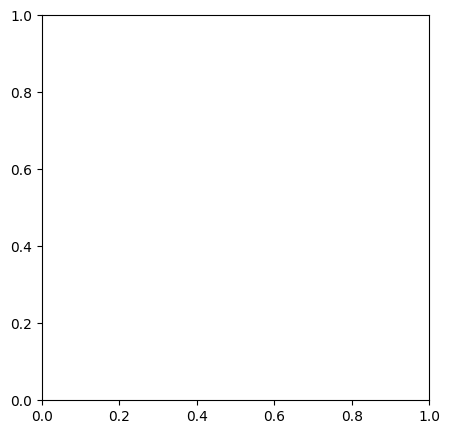

In [86]:
# Plot phase portraits for all pairs (if >2 types)
from itertools import combinations
from tdm.plot.two_cells.phase_portrait import plot_phase_portrait
import matplotlib.pyplot as plt

if len(cell_types_to_model) == 2:
    plot_phase_portrait(ana)
    plt.show()
else:
    for a, b in combinations(cell_types_to_model, 2):
        print(f'Plotting {a} vs {b}')
        ana_pair = Analysis(
            single_cell_df=single_cell_df,
            cell_types_to_model=[a, b],
            allowed_neighbor_types=allowed_neighbor_types,
            polynomial_dataset_kwargs={'degree': 1},
            neighborhood_mode='extrapolate',
            enforce_max_density=False,
            model_kwargs={'regularization_alpha': 1e-3},
        )
        plot_phase_portrait(ana_pair)
        plt.show()
